In [1]:
# Load libraries

import os
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pySuStaIn
import statsmodels.formula.api as smf
from scipy import stats
import sklearn.model_selection

/home/robin/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
# Load and view simulated tutorial data
# The data needs to be in the same directory as your notebook

data = pandas.read_csv('SimulatedData.csv')
data.head()

,RID,Diagnosis,Age,Headsize,Biomarker1,Biomarker2,Biomarker3,Biomarker4,Biomarker5
0,1,1,63.501953,0.920706,132.511729,180.698267,120.119201,159.200991,190.197486
1,2,1,61.240101,0.952784,154.500427,194.299318,179.148420,173.515194,237.807726
2,3,1,52.108876,1.061493,140.878957,170.449488,160.945261,163.988839,207.271331
3,4,1,65.989165,0.871652,146.361556,175.111234,164.769410,114.437784,184.657121
4,5,1,65.071640,1.147264,167.254806,203.470447,232.783278,212.857075,245.588402


In [3]:
data.Diagnosis.value_counts()

Diagnosis
1    467
0     33
Name: count, dtype: int64

In [15]:
# store our biomarker labels as a variable
biomarkers = data.columns[4:]
print(biomarkers)

Index(['Biomarker1', 'Biomarker2', 'Biomarker3', 'Biomarker4', 'Biomarker5'], dtype='object')


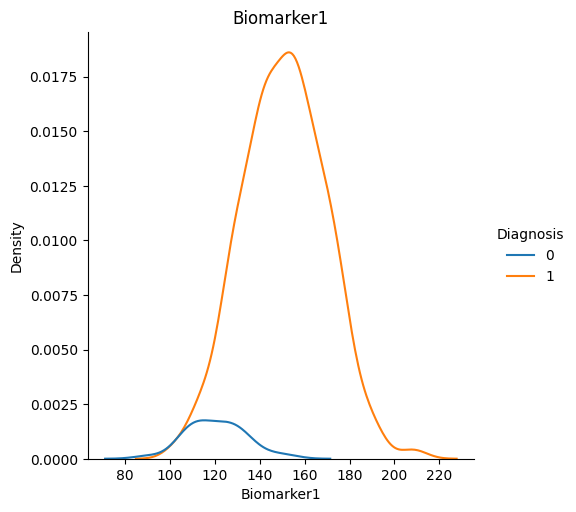

In [4]:
# first a quick look at the patient and control distribution for one of our biomarkers

biomarker = biomarkers[0]
sns.displot(data=data, # our dataframe
            x=biomarker, # name of the the distribution we want to plot
            hue='Diagnosis', # the "grouping" variable
            kind='kde') # kind can also be 'hist' or 'ecdf'
plt.title(biomarker)
plt.show()

<Axes: xlabel='Age', ylabel='Biomarker1'>

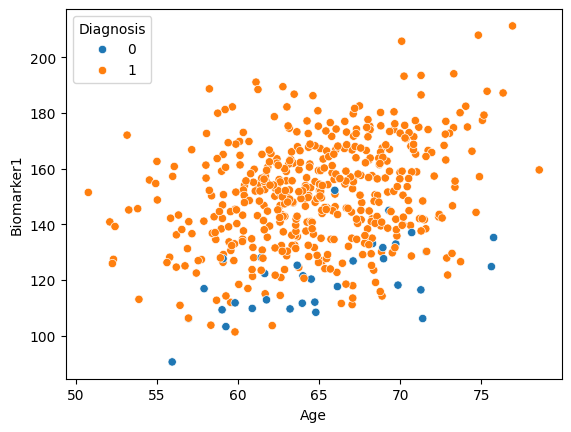

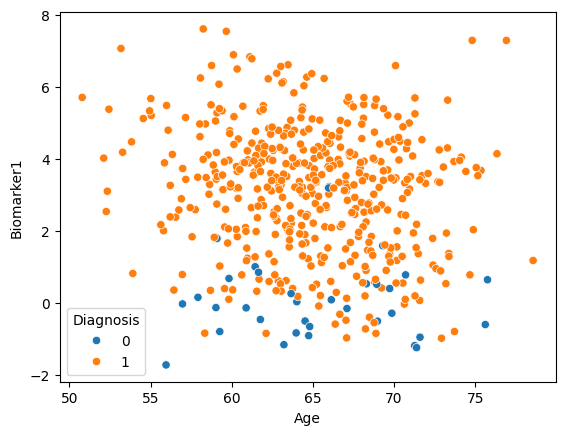

In [5]:
# now we perform the normalization

# make a copy of our dataframe (we don't want to overwrite our original data)
zdata = pandas.DataFrame(data,copy=True)

# for each biomarker
for biomarker in biomarkers:
    mod = smf.ols('%s ~ Age + Headsize'%biomarker,  # fit a model finding the effect of age and headsize on biomarker
                  data=data[data.Diagnosis==0] # fit this model *only* to individuals in the control group
                 ).fit() # fit model    
    #print(mod.summary())
    
    # get the "predicted" values for all subjects based on the control model parameters
    predicted = mod.predict(data[['Age','Headsize',biomarker]]) 
    
    # calculate our zscore: observed - predicted / SD of the control group residuals
    w_score = (data.loc[:,biomarker] - predicted) / mod.resid.std()
    
    #print(np.mean(w_score[data.Diagnosis==0]))
    #print(np.std(w_score[data.Diagnosis==0]))
    
    # save zscore back into our new (copied) dataframe
    zdata.loc[:,biomarker] = w_score
    
    
plt.figure(0)
sns.scatterplot(x=data.Age,y=data.Biomarker1,hue=data.Diagnosis)
plt.figure(1)
sns.scatterplot(x=zdata.Age,y=zdata.Biomarker1,hue=zdata.Diagnosis)

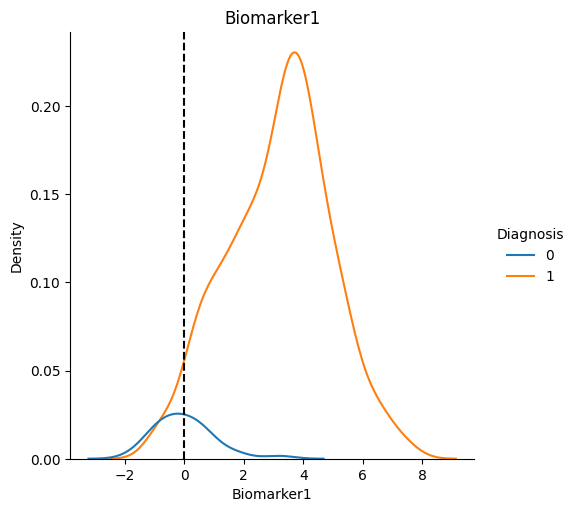

In [10]:
biomarker = biomarkers[0]
sns.displot(data=zdata,x=biomarker,hue='Diagnosis',kind='kde')
plt.title(biomarker)
plt.axvline(0,ls='--',c='black') # the 0 line *should* be the mean of the control distribution
plt.show()

In [16]:
N = len(biomarkers)         # number of biomarkers

SuStaInLabels = biomarkers
Z_vals = np.array([[1,2,3]]*N)     # Z-scores for each biomarker
Z_max  = np.array([5]*N)           # maximum z-score

In [12]:
print(Z_vals)

[[1 2 3]
 [1 2 3]
 [1 2 3]
 [1 2 3]]


In [17]:
# Input the settings for z-score SuStaIn
# To make the tutorial run faster I've set 
# N_startpoints = 10 and N_iterations_MCMC = int(1e4)
# I recommend using N_startpoints = 25 and 
# N_iterations_MCMC = int(1e5) or int(1e6) in general though

N_startpoints = 10
N_S_max = 1
N_iterations_MCMC = int(1e3)
output_folder = os.path.join(os.getcwd(), 'WorkshopOutput')
dataset_name = 'WorkshopOutput'

# Initiate the SuStaIn object
sustain_input = pySuStaIn.ZscoreSustain(
                              zdata[biomarkers].values,
                              Z_vals,
                              Z_max,
                              SuStaInLabels,
                              N_startpoints,
                              N_S_max, 
                              N_iterations_MCMC, 
                              output_folder, 
                              dataset_name, 
                              False)

In [18]:
# make the output directory if it's not already created
if not os.path.isdir(output_folder):
    os.mkdir(output_folder)

In [19]:
samples_sequence,   \
samples_f,          \
ml_subtype,         \
prob_ml_subtype,    \
ml_stage,           \
prob_ml_stage,      \
prob_subtype_stage  = sustain_input.run_sustain_algorithm()

Failed to find pickle file: /home/robin/sustaln/pySuStaIn/notebooks/WorkshopOutput/pickle_files/WorkshopOutput_subtype0.pickle. Running SuStaIn model for 0 subtype.
Finding ML solution to 1 cluster problem
Overall ML likelihood is -4738.922310063224


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/1000 [00:00<?, ?it/s]

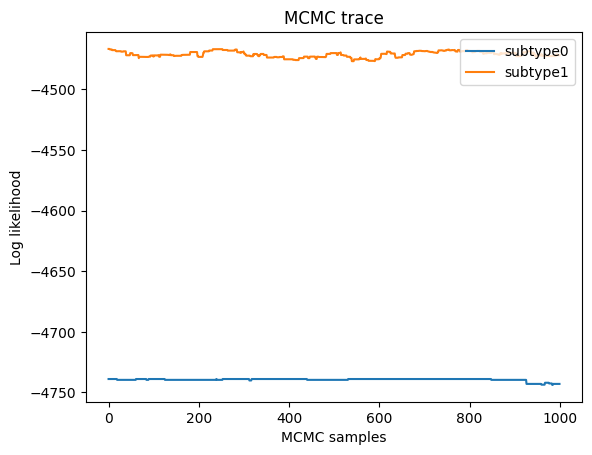

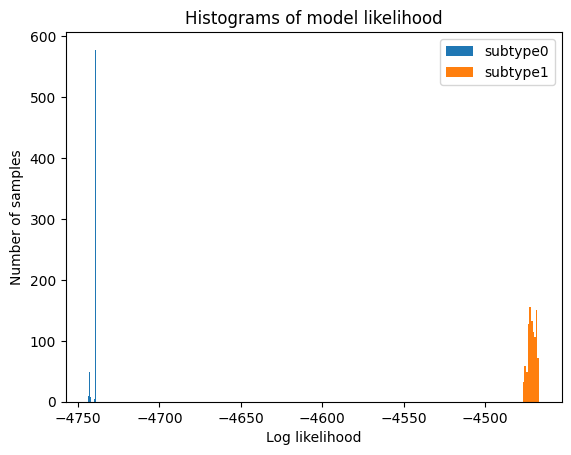

In [16]:
# for each subtype model
for s in range(N_S_max):
    # load pickle file (SuStaIn output) and get the sample log likelihood values
    pickle_filename_s = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
    pk = pandas.read_pickle(pickle_filename_s)
    samples_likelihood = pk["samples_likelihood"]
    
    # plot the values as a line plot
    plt.figure(0)
    plt.plot(range(N_iterations_MCMC), samples_likelihood, label="subtype" + str(s))
    plt.legend(loc='upper right')
    plt.xlabel('MCMC samples')
    plt.ylabel('Log likelihood')
    plt.title('MCMC trace')
    
    # plot the values as a histogramp plot
    plt.figure(1)
    plt.hist(samples_likelihood, label="subtype" + str(s))
    plt.legend(loc='upper right')
    plt.xlabel('Log likelihood')  
    plt.ylabel('Number of samples')  
    plt.title('Histograms of model likelihood')

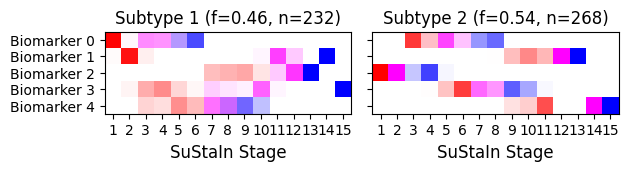

In [17]:
# Let's plot positional variance diagrams to interpret the subtype progressions

s = 1 # 1 split = 2 subtypes
M = len(zdata) 

# get the sample sequences and f
pickle_filename_s = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
pk = pandas.read_pickle(pickle_filename_s)
samples_sequence = pk["samples_sequence"]
samples_f = pk["samples_f"]

# use this information to plot the positional variance diagrams
tmp=pySuStaIn.ZscoreSustain._plot_sustain_model(sustain_input,samples_sequence,samples_f,M,subtype_order=(0,1))

In [18]:
# let's take a look at all of the things that exist in SuStaIn's output (pickle) file
pk.keys()

dict_keys(['samples_sequence', 'samples_f', 'samples_likelihood', 'ml_subtype', 'prob_ml_subtype', 'ml_stage', 'prob_ml_stage', 'prob_subtype', 'prob_stage', 'prob_subtype_stage', 'ml_sequence_EM', 'ml_sequence_prev_EM', 'ml_f_EM', 'ml_f_prev_EM'])

In [19]:
# The SuStaIn output has everything we need. We'll use it to populate our dataframe.

s = 1
pickle_filename_s = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
pk = pandas.read_pickle(pickle_filename_s)

for variable in ['ml_subtype', # the assigned subtype
                 'prob_ml_subtype', # the probability of the assigned subtype
                 'ml_stage', # the assigned stage 
                 'prob_ml_stage',]: # the probability of the assigned stage
    
    # add SuStaIn output to dataframe
    zdata.loc[:,variable] = pk[variable] 

# let's also add the probability for each subject of being each subtype
for i in range(s):
    zdata.loc[:,'prob_S%s'%i] = pk['prob_subtype'][:,i]
zdata.head()

,RID,Diagnosis,Age,Headsize,Biomarker1,Biomarker2,Biomarker3,Biomarker4,Biomarker5,ml_subtype,prob_ml_subtype,ml_stage,prob_ml_stage,prob_S0
0,1,1,63.501953,0.920706,1.965731,1.672779,1.059005,2.483225,2.124796,1.0,0.973942,7.0,0.194397,0.026058
1,2,1,61.240101,0.952784,4.438108,4.592943,3.743060,3.142156,5.466800,1.0,0.945015,15.0,0.415155,0.054985
2,3,1,52.108876,1.061493,4.019363,2.466467,2.680370,2.722724,3.748348,1.0,0.987419,12.0,0.301194,0.012581
3,4,1,65.989165,0.871652,3.228515,0.280077,3.202390,0.449164,1.708204,0.0,0.928073,6.0,0.255498,0.928073
4,5,1,65.071640,1.147264,4.009545,2.927119,6.189362,4.064417,5.027144,1.0,0.683812,15.0,0.462279,0.316188


In [20]:
# IMPORTANT!!! The last thing we need to do is to set all "Stage 0" subtypes to their own subtype
# We'll set current subtype (0 and 1) to 1 and 0, and we'll call "Stage 0" individuals subtype 0.

# make current subtypes (0 and 1) 1 and 2 instead
zdata.loc[:,'ml_subtype'] = zdata.ml_subtype.values + 1

# convert "Stage 0" subjects to subtype 0
zdata.loc[zdata.ml_stage==0,'ml_subtype'] = 0

In [21]:
zdata.ml_subtype.value_counts()


ml_subtype
1.0    244
2.0    217
0.0     39
Name: count, dtype: int64

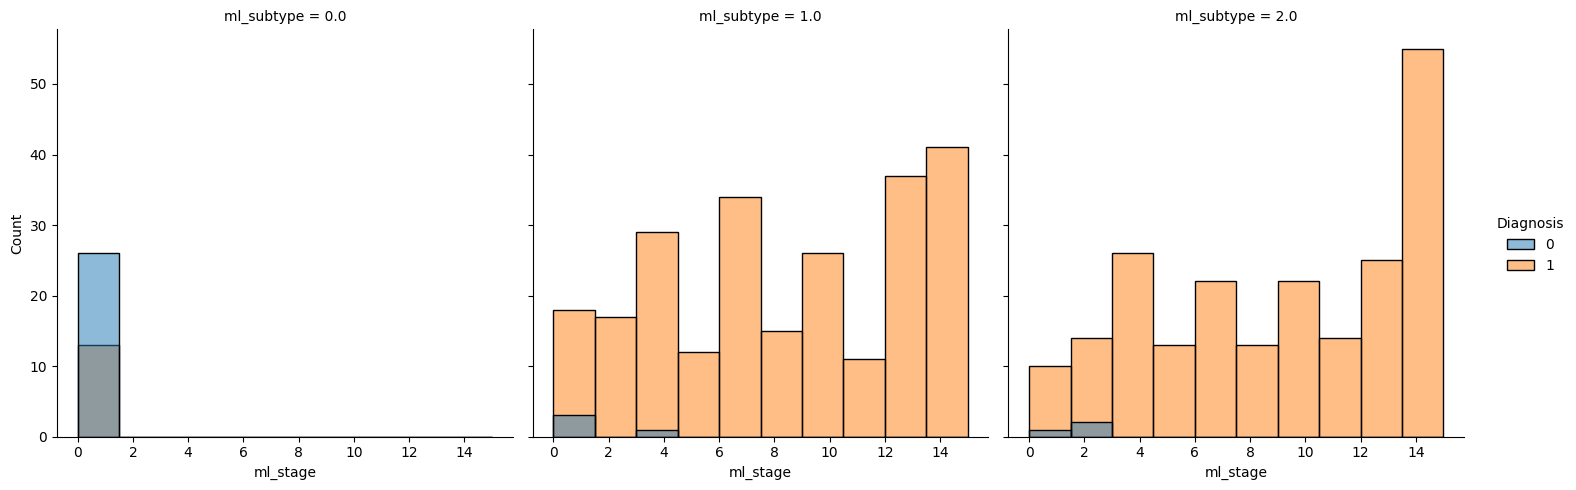

In [22]:
sns.displot(x='ml_stage',hue='Diagnosis',data=zdata,col='ml_subtype')


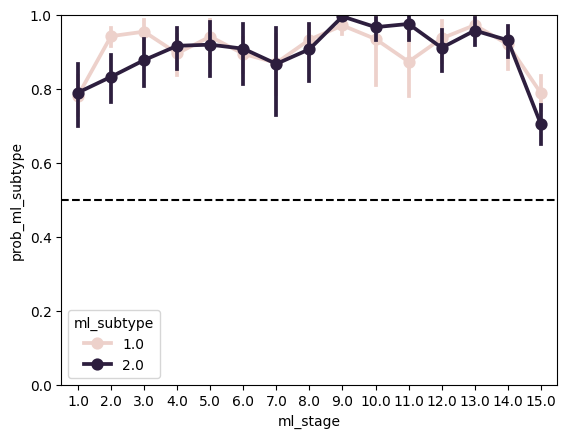

In [23]:
sns.pointplot(x='ml_stage',y='prob_ml_subtype', # input variables
              hue='ml_subtype',                 # "grouping" variable
            data=zdata[zdata.ml_subtype>0]) # only plot for Subtypes 1 and 2 (not 0)
plt.ylim(0,1) 
plt.axhline(0.5,ls='--',color='k') # plot a line representing change (0.5 in the case of 2 